<a href="https://colab.research.google.com/drive/1O68xgMkOwAnqQSRip0MBSlDSPbDy_lw7?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de regresión logística y balanceo ROS

### 1. Visualización

In [104]:
# Importamos librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

In [105]:
# Extraemos datos
data='/content/para volumen 4ta vuelta.csv'

In [106]:
#visualizamos el dataset
df= pd.read_csv(data)
df.head()

,C,Rp,Dif_vol,V_in,V_out,P_ventilador,PIP,Error_aceptable
0,20,20,-2.7,350,352.7,27.6,25.5,1
1,20,20,-4.7,350,354.7,30.3,30.2,1
2,20,20,1.2,350,348.8,32.0,33.0,1
3,20,20,3.1,400,396.9,30.3,29.4,1
4,20,20,-7.0,400,407.0,33.9,34.3,1


Podemos observar que podríamos considerar la variable Dif_vol que incluye en una sola variable la diferencia de volumen, en lugar de V_in y V_out. Además, también consideraremos P_ventilador como variable.

### 2. Filtrado de data

In [107]:
#Revisamos dimension de la data
df.shape

(69, 8)

In [108]:
#filtramos decartando columnas con datos faltantes
d_filtrado = df.dropna().copy() 

In [109]:
#Verificamos cuantos valores tenemos de Rp
d_filtrado.V_out.unique()

array([352.7, 354.7, 348.8, 396.9, 407. , 401.6, 442.2, 455.5, 451.2,
       482.2, 492. , 494.5, 541.7, 549.6, 558.5, 597.3, 599. , 612.5,
       327.8, 307.5, 303.2, 375. , 360.8, 358.6, 419.6, 408.8, 407.5,
       455.2, 457.3, 461.5, 518.2, 515.8, 524.4, 574. , 571.6, 296.8,
       281.3, 277.5, 335.2, 332.8, 330.7, 382. , 377. , 383. , 436.4,
       429.6, 436.5, 498.1, 496.1, 499.6, 552. , 548.8, 269. , 302.6,
       302.7, 303. , 344.1, 344.2, 389.1, 396.6, 386.5, 435.7, 452.7,
       487.9, 509.7, 527. , 544.5, 559.9])

In [110]:
#revisamos de la data filtrada
d_filtrado.shape

(69, 8)

### 3. Revisar proporciones y calcular error aceptable

In [111]:
#contar valores
d_filtrado['Error_aceptable'].value_counts()

1    53
0    16
Name: Error_aceptable, dtype: int64

In [112]:
#revisamos proporción
d_filtrado['Error_aceptable'].value_counts()/len(d_filtrado)

1    0.768116
0    0.231884
Name: Error_aceptable, dtype: float64

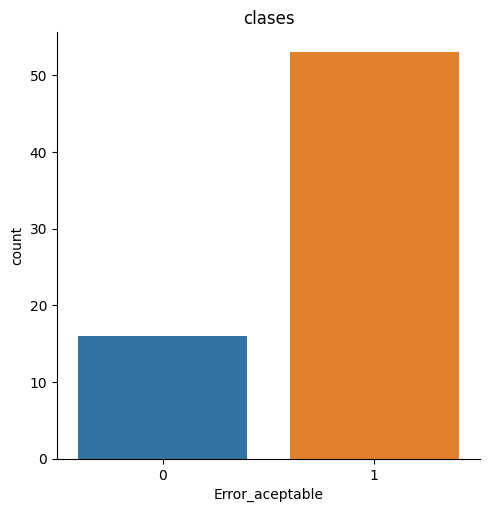

In [113]:
#observamos el desbalance de datos
p=sns.catplot(data = d_filtrado, kind ='count', x= 'Error_aceptable')
p.set(title = "clases")

In [114]:
# definimos la matriz de caracteristicas
x = d_filtrado.loc[:,['Dif_vol','P_ventilador']]
y = d_filtrado['Error_aceptable']

In [115]:
print(len(y[y==0]))
print(len(y[y==1]))

16
53


### 4. División de data y estandarización

In [116]:
#divimos la data en conjunto de entranimiento y test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 0)
print(len(x_train),len(x_test))

51 18


In [117]:
print(len(y_train[y_train==0]))
print(len(y_train[y_train==1]))


11
40


In [118]:
# Estandarización de características
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [119]:
print(df.head())

    C  Rp  Dif_vol  V_in  V_out  P_ventilador   PIP  Error_aceptable
0  20  20     -2.7   350  352.7          27.6  25.5                1
1  20  20     -4.7   350  354.7          30.3  30.2                1
2  20  20      1.2   350  348.8          32.0  33.0                1
3  20  20      3.1   400  396.9          30.3  29.4                1
4  20  20     -7.0   400  407.0          33.9  34.3                1


### 5. Modelo de regresión logística

In [120]:
from sklearn.linear_model import LogisticRegression
regLog = LogisticRegression(random_state = 0)
regLog.fit(x_train,y_train)

LogisticRegression(random_state=0)

In [121]:
# Se anñade una columna constante para el término de intercepción
x_train_with_const = sm.add_constant(x_train)

# Crear un modelo logístico con statsmodels
logit_model = sm.Logit(y_train, x_train_with_const)

# Ajustar el modelo
result = logit_model.fit()

# Obtener los coeficientes y los p-valores
coefficients = result.params
p_values = result.pvalues

print("Coeficientes:")
print(coefficients)
print("\nP-valores:")
print(p_values)

Optimization terminated successfully.
         Current function value: 0.085406
         Iterations 12
Coeficientes:
const    12.823493
x1      -16.051232
x2        4.479276
dtype: float64

P-valores:
const    0.064688
x1       0.062743
x2       0.082921
dtype: float64


In [122]:
score = regLog.score(x_test, y_test)
round(score,4)

0.8889

In [123]:
y_pred = regLog.predict(x_test)

### 6. Revisión de métricas

In [124]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.87      1.00      0.93        13

    accuracy                           0.89        18
   macro avg       0.93      0.80      0.84        18
weighted avg       0.90      0.89      0.88        18



Observamos que obtenemos una mejor precisión que al usar Vin y Vout, probablemente porque el modelo tiene más información de los datos.

In [125]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 3  2]
 [ 0 13]]


In [126]:
pd.crosstab(y_test,y_pred)

col_0,0,1
Error_aceptable,,
0,3,2
1,0,13


In [127]:
# K-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regLog, X = x_train, y=y_train, cv= 10)
accuracies.mean()

0.9066666666666666

In [128]:
accuracies

array([0.66666667, 0.8       , 1.        , 0.8       , 1.        ,
       1.        , 1.        , 0.8       , 1.        , 1.        ])

<ipython-input-129-ec8f2907d3fb>:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x_set[y_set == j,0],x_set[y_set== j,1],


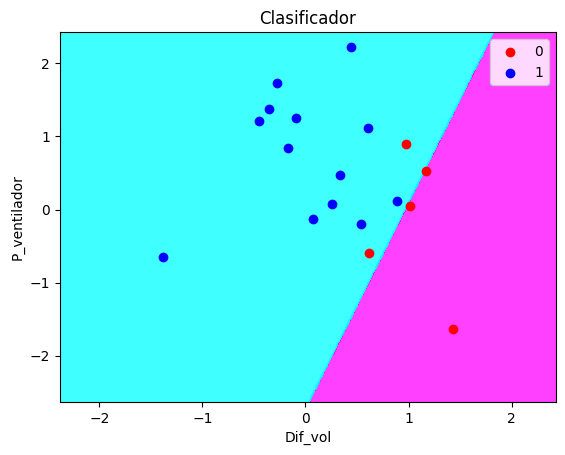

In [129]:
# Creamos un plot para ver la frontera de clasificación

from matplotlib.colors import ListedColormap
x_set, y_set = x_test, y_test
X1,X2 = np.meshgrid(np.arange(start = x_set[:,0].min()-1,stop = x_set[:,0].max()+1,step=0.01),
                    np.arange(start = x_set[:,1].min()-1,stop = x_set[:,0].max()+1,step=0.01))
plt.contourf(X1,X2, regLog.predict(np.array([X1.ravel(),X2.ravel()]).T).reshape(X1.shape),
             alpha=0.75, cmap = ListedColormap(('magenta', 'cyan')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i,j in enumerate(np.unique(y_set)):
    plt.scatter(x_set[y_set == j,0],x_set[y_set== j,1],
                c = ListedColormap(('red','blue'))(i),label = j)
    
plt.title('Clasificador')
plt.xlabel('Dif_vol')
plt.ylabel('P_ventilador')
plt.legend()
plt.show()



### 7. Balanceo ROS
Con el fin de mejorar la precisión del modelo

In [130]:
len(x_train)

51

In [131]:
train = np.concatenate([x_train, y_train.values.reshape(-1,1)], axis=1)

In [132]:
#transformamos a un dataFrame
train = pd.DataFrame(train,columns=['Dif_vol','P_ventilador','Error_aceptable'])

In [133]:
#obtenemos la clase con error que no se acepta
train_class_0 = train.query("Error_aceptable == 0")
train_class_0.head()

,Dif_vol,P_ventilador,Error_aceptable
10,1.052039,0.223825,0.0
12,1.087821,0.960943,0.0
13,0.616145,-0.779474,0.0
16,1.953103,-1.363025,0.0
20,0.528316,-0.984229,0.0


In [134]:
train_class_0.shape

(11, 3)

In [135]:
n_class0 = len(train.query("Error_aceptable == 0"))
n_class1 = len(train.query("Error_aceptable == 1"))
print ( n_class0, n_class1)

11 40


In [136]:
i_class0_downsampled = train_class_0.sample(n_class1,replace = True)
len(i_class0_downsampled)

40

In [137]:
new_train = pd.concat([train.query("Error_aceptable == 1"), i_class0_downsampled], axis=0)
new_train[['Error_aceptable']].value_counts()

Error_aceptable
0.0                40
1.0                40
dtype: int64

In [138]:
new_x_train =new_train.loc[:,['Dif_vol','P_ventilador']].values
new_y_train =new_train.loc[:,['Error_aceptable']].values


In [139]:
new_y_train = pd.Series(new_y_train.reshape(-1,))

In [140]:
new_train.loc[:,['Error_aceptable']].value_counts()

Error_aceptable
0.0                40
1.0                40
dtype: int64

Nuevo modelo con nueva data

In [141]:
model= LogisticRegression()
model. fit(new_x_train, new_y_train)

LogisticRegression()

In [142]:
y_pred2 = model.predict(x_test)

In [143]:
print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.87      1.00      0.93        13

    accuracy                           0.89        18
   macro avg       0.93      0.80      0.84        18
weighted avg       0.90      0.89      0.88        18

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.85      0.92        13

    accuracy                           0.89        18
   macro avg       0.86      0.92      0.88        18
weighted avg       0.92      0.89      0.89        18



Tras realizar el balanceo ROS podemos observar una mejoría en el f1-score al momento de predecir 0s, mostrando una mayor sensibilidad en sacrificio de la precisión.

El f1-score se redujo ligeramente en el caso de los resultados positivios, y en términos generales la exactitud del modelo se mantuvo igual, mejorando la media macro y la media ponderada.